#### Relationship Method of Admission with Student Success or Dropout Risks 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('spQ3.csv')
df.head()

,Application mode,Application order,Course,Previous qualification,Previous qualification (grade),Admission grade,Target_status
0,17,5,171,1,122.0,127.3,1
1,15,1,9254,1,160.0,142.5,2
2,1,5,9070,1,122.0,124.8,1
3,17,2,9773,1,122.0,119.6,2
4,39,1,8014,1,100.0,141.5,2


In [5]:
df.shape

(4424, 7)

In [ ]:
# Set labels 1 = Dropout, 2 = Enrolled, 3 = Graduate
target_map = {1:"Dropout", 2:"Enrolled", 3:"Graduate"}
df["Status"] = df["Target_status"].map(target_map)

sns.set(style="whitegrid")


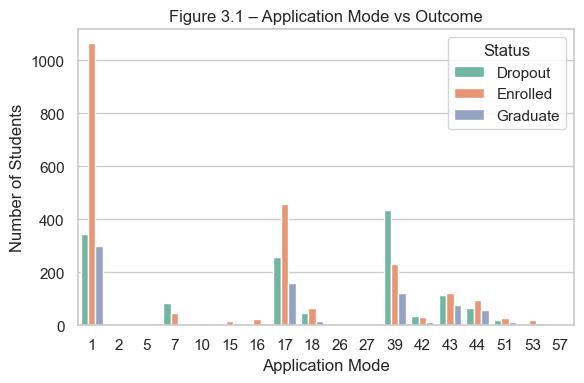

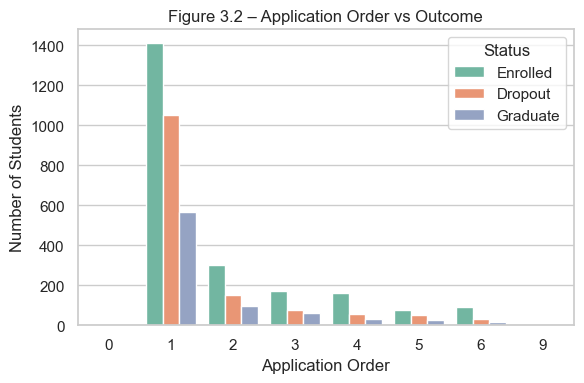

C:\Users\shafi\AppData\Local\Temp\ipykernel_18320\3796633499.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Status", y="Admission grade", palette="Set3")


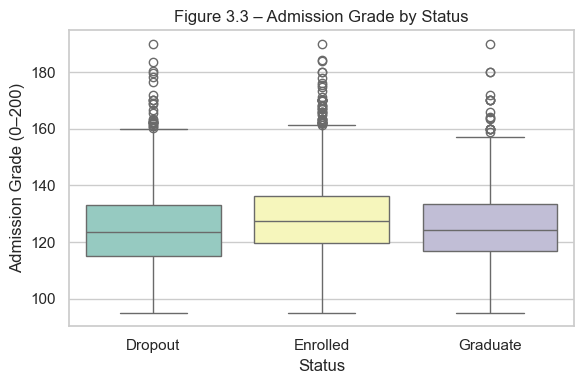

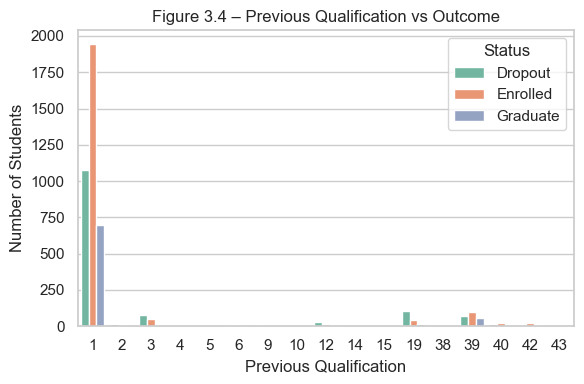

In [26]:
# Figure 3.1 – Application Mode vs Outcome
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Application mode", hue="Status", palette="Set2")
plt.title("Figure 3.1 – Application Mode vs Outcome")
plt.xlabel("Application Mode"); plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout(); plt.show()

# Figure 3.2 – Application Order vs Outcome
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Application order", hue="Status", palette="Set2")
plt.title("Figure 3.2 – Application Order vs Outcome")
plt.xlabel("Application Order"); plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout(); plt.show()

# Figure 3.3 – Admission Grade by Status
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Status", y="Admission grade", palette="Set3")
plt.title("Figure 3.3 – Admission Grade by Status")
plt.xlabel("Status"); plt.ylabel("Admission Grade (0–200)")
plt.tight_layout(); plt.show()

# Figure 3.4 – Previous Qualification vs Outcome
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Previous qualification", hue="Status", palette="Set2")
plt.title("Figure 3.4 – Previous Qualification vs Outcome")
plt.xlabel("Previous Qualification"); plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout(); plt.show()



c:\Users\shafi\OneDrive\Documents\GitHub\DataScienceProject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\shafi\OneDrive\Documents\GitHub\DataScienceProject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression (Q3) ===
              precision    recall  f1-score   support

           1      0.527     0.518     0.522       284
           2      0.687     0.627     0.656       442
           3      0.320     0.409     0.359       159

    accuracy                          0.553       885
   macro avg      0.511     0.518     0.512       885
weighted avg      0.570     0.553     0.560       885


=== Random Forest (Q3) ===
              precision    recall  f1-score   support

           1      0.459     0.458     0.459       284
           2      0.612     0.688     0.647       442
           3      0.305     0.201     0.242       159

    accuracy                          0.527       885
   macro avg      0.459     0.449     0.449       885
weighted avg      0.508     0.527     0.514       885

RF AUC (OvR): 0.6457392445201405
RF AUC (OvO): 0.6367061590541762


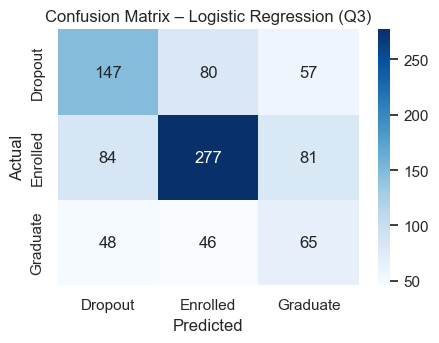

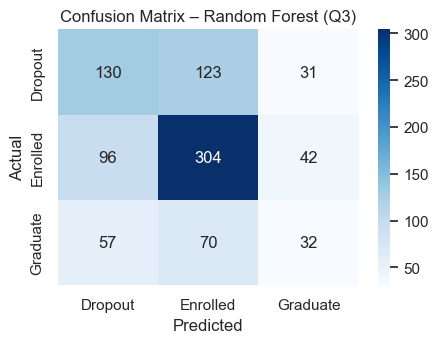


Top 10 Admission Predictors (Random Forest):
Admission grade                   0.360839
Previous qualification (grade)    0.255725
Application order                 0.068604
Application mode_39               0.021678
Course_9500                       0.021454
Application mode_1                0.017751
Course_9119                       0.013939
Course_9238                       0.013431
Course_9147                       0.012500
Course_8014                       0.011451


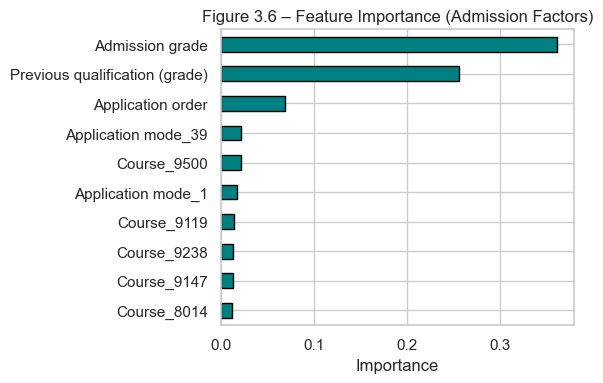

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

features_q3 = [
    "Application mode", "Application order", "Course",
    "Previous qualification", "Previous qualification (grade)",
    "Admission grade"
]

X = df[features_q3].copy()
y = df["Target_status"].astype(int)   # 1=Dropout, 2=Enrolled, 3=Graduate

# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = ["Application order", "Previous qualification (grade)", "Admission grade"]
cat_cols = [c for c in features_q3 if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    sparse_threshold=0
)

# 2 models: Logistic Regression & Random Forest
log_clf = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1500, class_weight="balanced", multi_class="ovr"))
])

rf_clf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1
    ))
])

# Fit models
log_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Evaluate: classification report 
print("=== Logistic Regression (Q3) ===")
y_pred_log = log_clf.predict(X_test)
print(classification_report(y_test, y_pred_log, digits=3))

print("\n=== Random Forest (Q3) ===")
y_pred_rf = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_rf, digits=3))

# Multiclass AUC (One-vs-Rest / One-vs-One)
try:
    y_proba_rf = rf_clf.predict_proba(X_test)
    print("RF AUC (OvR):", roc_auc_score(y_test, y_proba_rf, multi_class="ovr"))
    print("RF AUC (OvO):", roc_auc_score(y_test, y_proba_rf, multi_class="ovo"))
except Exception:
    pass

# Confusion matrices (both models) – heatmap
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3])
    plt.figure(figsize=(4.6,3.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Dropout","Enrolled","Graduate"],
                yticklabels=["Dropout","Enrolled","Graduate"])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

plot_cm(y_test, y_pred_log, "Confusion Matrix – Logistic Regression (Q3)")
plot_cm(y_test, y_pred_rf,  "Confusion Matrix – Random Forest (Q3)")

ohe = rf_clf.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
all_names = num_cols + cat_names

importances = rf_clf.named_steps["clf"].feature_importances_
fi = pd.Series(importances, index=all_names).sort_values(ascending=False)

print("\nTop 10 Admission Predictors (Random Forest):")
print(fi.head(10).to_string())

plt.figure(figsize=(6,4))
fi.head(10).sort_values().plot(kind="barh", color="teal", edgecolor="black")
plt.title("Figure 3.6 – Feature Importance (Admission Factors)")
plt.xlabel("Importance"); plt.ylabel("")
plt.tight_layout(); plt.show()
